<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/Scripts_Generative/pytorch/WGANGP_CIFAR10_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WGAN-GP

元論文 : Improved Training of Wasserstein GANs https://arxiv.org/abs/1704.00028 (2017)

### 論文のサマリ 

WGANのパラメータのクリッピングは最適化を難しくするというのがWGAN-GPの導入背景。
Critic(DiscriminatorをWGANの論文ではCriticと呼ぶ)にBatch Normalizationが入っているとパラメータのクリッピング問題は弱めることができるけど、深いCriticでは収束しにくいらしい。

Criticのパラメータを[-c, c]にクリッピングするが、cの値を注意深く選ばないと勾配消失か勾配爆発になってしまう。しかし、WGANでWasserstain距離を用いた画像でLossを作るために1Lipschits制約を実現するために、このクリッピングが必要だった。

なので、**WGAN-GPでは勾配を1に近づける正則化項（=GP : Gradient Penalty) を導入することで、クリッピングを行わずに1Lipschits制約を実現する。**

ただし、BatchNormalizationはバッチで正規化するけど、GPは入力毎に行うので、相性が悪い。CriticではBatchNormalizationの代わりにLayerNormalizationを入れた。(これで結果も良くなった)

以上がWGAN-GPの論文での主張

DCGAN, LSGAN, WGAN, WGAN-GPを比較するために、GeneratorとDiscriminatorにいろんな条件をつけて LSUNデータセットで試した。その結果がFigure.2。WGAN-GPがずば抜けていい画像を作っている。しかもRes101をGとDに使ってもモード崩壊に陥らないという。

### アルゴリズム

WGAN-GPのアルゴリズムは、イテレーション毎に以下のDiscriminatorとGeneratorの学習を交互に行っていく。
- 最適化 : Adam (LearningRate: 0.0001, β1=0, β2=0.9)
- λ = 10

アルゴリズム

#### Discriminatorの学習(以下をcriticの回数だけ繰り返す）

1. ノイズzをサンプリングし、 $G_z = G(z)$ を求める
2. $\epsilon \in [0, 1]$ をランダムに選び、Realデータ$X$ と　$G_z$ の重み付き平均 $\hat{x} = \epsilon X + (1 - \epsilon) G_z$ を計算する
3. Loss $L^i = D(G_z) - D(X) + \lambda (\| \nabla_{\hat{x}} D(\hat{x}) \|_2 - 1)^2$　を計算し、SGD

#### Generatorの学習

1. ノイズzをサンプリングして、 Loss $L = \frac{1}{|Minibatch|} \sum_{i} - D(G(z))$ を計算し、SGD

GeneratorとDiscriminatorの構造は次の通り。WGAN-GPではResBlock構造を導入して、Deepな構造にしている。

#### Generator

ResNetの活性化関数はReLU

<img src='https://github.com/yoyoyo-yo/DeepLearningMugenKnock/blob/master/Scripts_Generative/assets/WGAN-gp_D.png' width=600>

#### Discriminator

ResNetの活性化関数はLeakyReLU(0.2)

<img src='https://github.com/yoyoyo-yo/DeepLearningMugenKnock/blob/master/Scripts_Generative/assets/WGAN-gp_D.png' width=600>

それぞれにおいてResBlockは以下の構造となる

#### ResBlock

<img src='../assets/WGAN-gp_ResBlock.png' width=300>

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install numpy matplotlib opencv-python torch torchvision torchsummary pandas easydict

## Import and Config

In [7]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
from pprint import pprint

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/pytorch/')
from _main_base_generative import *

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = ['akahara', 'madara'] # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_Z_DIM = 128
cfg.INPUT_MODE = None

cfg.OUTPUT_HEIGHT = 32
cfg.OUTPUT_WIDTH = 32
cfg.OUTPUT_CHANNEL = 3
cfg.OUTPUT_MODE = 'RGB'  # RGB, GRAY, EDGE, CLASS_LABEL

cfg.G_DIM = 32
cfg.D_DIM = 32
cfg.RES_BLOCK_DIM = 64

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = True
cfg.DEVICE_TYPE = 'cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu'
cfg.DEVICE = torch.device(cfg.DEVICE_TYPE)

# train
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'WGAN-GP-cifar10'
cfg.TRAIN.MODEL_G_SAVE_PATH = 'models/' + cfg.PREFIX + '_G_{}.pt'
cfg.TRAIN.MODEL_D_SAVE_PATH = 'models/' + cfg.PREFIX + '_D_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 200
cfg.TRAIN.ITERATION = 10_000
cfg.TRAIN.MINIBATCH = 64
cfg.TRAIN.OPTIMIZER_G = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_G = {'lr' : 0.0001, 'betas' : (0., 0.9)}
cfg.TRAIN.OPTIMIZER_D = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_D = {'lr' : 0.0001, 'betas' : (0., 0.9)}
cfg.TRAIN.LOSS_FUNCTION = None

cfg.TRAIN.DATA_PATH = './data/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = False # data augmentation : holizontal flip
cfg.TRAIN.DATA_VERTICAL_FLIP = False # data augmentation : vertical flip
cfg.TRAIN.DATA_ROTATION = False # data augmentation : rotation False, or integer

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 500
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.txt'

#---
# WGAN  config
#---
cfg.TRAIN.WGAN_CRITIC_N = 5
cfg.TRAIN.WGAN_GP_LAMBDA = 10

# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_G_PATH = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = './data'
cfg.TEST.MINIBATCH = 10
cfg.TEST.ITERATION = 2
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_G_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_D_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)

pprint(cfg)

{'CHANNEL_AXIS': 1,
 'CLASS_LABEL': ['akahara', 'madara'],
 'CLASS_NUM': 2,
 'DEVICE': device(type='cuda'),
 'DEVICE_TYPE': 'cuda',
 'D_DIM': 32,
 'GPU': True,
 'G_DIM': 32,
 'INPUT_MODE': None,
 'INPUT_Z_DIM': 128,
 'OUTPUT_CHANNEL': 3,
 'OUTPUT_HEIGHT': 32,
 'OUTPUT_MODE': 'RGB',
 'OUTPUT_WIDTH': 32,
 'PREFIX': 'WGAN-GP-cifar10',
 'RES_BLOCK_DIM': 64,
 'TEST': {'DATA_PATH': './data',
          'ITERATION': 2,
          'MINIBATCH': 10,
          'MODEL_G_PATH': 'models/WGAN-GP-cifar10_G_final.pt',
          'RESULT_IMAGE_PATH': 'result/WGAN-GP-cifar10_result_{}.jpg',
          'RESULT_SAVE': False},
 'TRAIN': {'DATA_HORIZONTAL_FLIP': False,
           'DATA_PATH': './data/',
           'DATA_ROTATION': False,
           'DATA_VERTICAL_FLIP': False,
           'DISPAY_ITERATION_INTERVAL': 50,
           'ITERATION': 10000,
           'LEARNING_PARAMS_D': {'betas': [0.0, 0.9], 'lr': 0.0001},
           'LEARNING_PARAMS_G': {'betas': [0.0, 0.9], 'lr': 0.0001},
           'LEARNING_PROCE

## Define Model

In [0]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

class Reshape(torch.nn.Module):
    def __init__(self, c, h, w):
        super(Reshape, self).__init__()
        self.c = c
        self.h = h
        self.w = w
    
    def forward(self, x):
        return x.view(x.size()[0], self.c, self.h, self.w)

    
# ResNet block
class ResBlock(torch.nn.Module):
    def __init__(self, dim_first=None, dim=cfg.RES_BLOCK_DIM, activation_fn=torch.nn.ReLU(), batch_norm=False, name=''):
        super(ResBlock, self).__init__()

        if dim_first is None:
            dim_first = dim
        #else:
        if batch_norm:
            self.skip_conv = torch.nn.Sequential(OrderedDict({
                name + '_skip_bn' : torch.nn.BatchNorm2d(dim_first),
                name + '_skip_activation' : activation_fn,
                name + '_skip_conv' : torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1)
            }))
        else:
            self.skip_conv = torch.nn.Sequential(OrderedDict({
                name + '_skip_activation' : activation_fn,
                name + '_skip_conv' : torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1)
            }))
        
        if batch_norm:
            self.block = torch.nn.Sequential(OrderedDict({
                name + '_layer_1_bn' : torch.nn.BatchNorm2d(dim_first),
                name + '_layer_1_activation' : activation_fn,
                name + '_layer_1_conv' : torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1),
                name + '_layer_2_bn' : torch.nn.BatchNorm2d(dim),
                name + '_layer_2_activation' : activation_fn,
                name + '_layer_2_conv' : torch.nn.Conv2d(dim, dim, kernel_size=3, padding=1, stride=1)
            }))
        else:
            self.block = torch.nn.Sequential(OrderedDict({
                name + '_layer_1_activation' : activation_fn,
                name + '_layer_1_conv' : torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1),
                name + '_layer_2_activation' : activation_fn,
                name + '_layer_2_conv' : torch.nn.Conv2d(dim, dim, kernel_size=3, padding=1, stride=1)
            }))


    def forward(self, x):
        res_x = self.block(x)

        if hasattr(self, 'skip_conv'):
            x = self.skip_conv(x)
        
        return F.relu(res_x + x)

    
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            #'G_layer_1' : torch.nn.Linear(cfg.INPUT_Z_DIM, cfg.G_DIM * (cfg.OUTPUT_HEIGHT // 8) * (cfg.OUTPUT_WIDTH // 8)),
            #'G_layer_1_reshape' : Reshape(cfg.G_DIM, cfg.OUTPUT_HEIGHT // 8, cfg.OUTPUT_HEIGHT // 8),
            'G_layer_1' : torch.nn.ConvTranspose2d(cfg.INPUT_Z_DIM, cfg.G_DIM, 
                                                     kernel_size=[cfg.OUTPUT_HEIGHT // 8, cfg.OUTPUT_WIDTH // 8], stride=1, padding=0),
            'G_layer_1_bn' : torch.nn.BatchNorm2d(cfg.G_DIM),
            'G_layer_1_activation' : torch.nn.ReLU(),     
            
            'G_layer_2_resBlock' : ResBlock(dim_first=cfg.G_DIM, activation_fn=torch.nn.ReLU(), batch_norm=True, name='G_resBlock_1'),
            'G_layer_2_upsampling' : torch.nn.UpsamplingBilinear2d(scale_factor=2),
            
            'G_layer_3_resBlock' : ResBlock(activation_fn=torch.nn.ReLU(), batch_norm=True, name='G_resBlock_2'),
            'G_layer_3_upsampling' : torch.nn.UpsamplingBilinear2d(scale_factor=2),
            
            'G_layer_4_resBlock' : ResBlock(activation_fn=torch.nn.ReLU(), batch_norm=True, name='G_resBlock_3'),
            'G_layer_4_upsampling' : torch.nn.UpsamplingBilinear2d(scale_factor=2),
        
            'G_layer_out' : torch.nn.Conv2d(cfg.RES_BLOCK_DIM, cfg.OUTPUT_CHANNEL, kernel_size=3, stride=1, padding=1),
            'G_layer_out_activation' : torch.nn.Tanh(),
        }))
        
    def forward(self, x):
        return self.module(x)


class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()    
        self.module = torch.nn.Sequential(OrderedDict({
            'D_layer_1_resBlock' : ResBlock(dim_first=cfg.OUTPUT_CHANNEL, dim=cfg.D_DIM, 
                                            activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False, name='D_resBlock_1'),
            'D_layer_1_pool' : torch.nn.AvgPool2d(2, stride=2),

            'D_layer_2_resBlock' : ResBlock(dim_first=cfg.D_DIM, activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False, name='D_resBlock_2'),
            'D_layer_2_pool' : torch.nn.AvgPool2d(2, stride=2),

            'D_layer_3_resBlock' : ResBlock(activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False, name='D_resBlock_3'),

            'D_layer_4_resBlock' : ResBlock(activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False, name='D_resBlock_4'),
            'D_layer_4_activation' : torch.nn.ReLU(),

            'D_layer_out' : torch.nn.Conv2d(cfg.RES_BLOCK_DIM, 1, kernel_size=[cfg.OUTPUT_HEIGHT // 4, cfg.OUTPUT_WIDTH // 4], 
                                            stride=1, padding=0),
            'D_layer_out_flatten' : Flatten()
            #'D_layer_5_pool' : torch.nn.AdaptiveAvgPool2d((1, 1)),
            #'D_layer_5_flatten' : Flatten(),
            #'D_layer_out' : torch.nn.Linear(cfg.D_DIM, 1),
        }))

    def forward(self, x):
        return self.module(x)

    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('bn') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

## Utility

In [0]:
def result_show(G, z, path=None, save=False, show=False,  figsize=(12, 4), cmap=None):
    if (save or show) is False:
        print('argument save >> {} and show >> {}, so skip')
        return

    Gz = G(z)
    Gz = Gz.detach().cpu().numpy()

    Gz = (Gz * 127.5 + 127.5).astype(np.uint8)
    Gz = Gz.reshape([-1, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])
    Gz = Gz.transpose(0, 2, 3, 1)

    plt.figure(figsize=figsize)
    
    for i in range(cfg.TEST.MINIBATCH):
        _G = Gz[i]
        plt.subplot(1, cfg.TEST.MINIBATCH, i + 1)
        plt.imshow(_G, cmap=cmap)
        plt.axis('off')

    if path is not None:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()

## Train

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [-1, 32, 4, 4]          65,568
       BatchNorm2d-2             [-1, 32, 4, 4]              64
              ReLU-3             [-1, 32, 4, 4]               0
       BatchNorm2d-4             [-1, 32, 4, 4]              64
              ReLU-5             [-1, 32, 4, 4]               0
              ReLU-6             [-1, 32, 4, 4]               0
            Conv2d-7             [-1, 64, 4, 4]          18,496
       BatchNorm2d-8             [-1, 64, 4, 4]             128
              ReLU-9             [-1, 64, 4, 4]               0
             ReLU-10             [-1, 64, 4, 4]               0
           Conv2d-11             [-1, 64, 4, 4]          36,928
      BatchNorm2d-12             [-1, 32, 4, 4]              64
             ReLU-13             [-1, 32, 4, 4]               0
             ReLU-14             [-1, 3

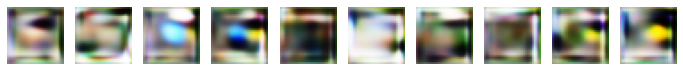

Iter:550, LossG (fake:-25317.5703), LossD:4640.5635 (real:-23925.3125, fake:-20362.5488), WDistance:-3562.7637, GP:1077.7996
Iter:600, LossG (fake:-26856.5234), LossD:7096.8145 (real:-36458.9766, fake:-31943.9414), WDistance:-4515.0352, GP:2581.7795
save G >> models/WGAN-GP-cifar10_G_iter600.pt, D >> models/WGAN-GP-cifar10_D_iter600.pt
Iter:650, LossG (fake:-29088.9043), LossD:5048.1450 (real:-28222.6719, fake:-24478.1484), WDistance:-3744.5234, GP:1303.6216
Iter:700, LossG (fake:-16740.3281), LossD:4260.0889 (real:-21441.1406, fake:-18844.3867), WDistance:-2596.7539, GP:1663.3347
Iter:750, LossG (fake:-19518.3984), LossD:4403.8691 (real:-26589.5938, fake:-23745.0039), WDistance:-2844.5898, GP:1559.2791
Iter:800, LossG (fake:-31491.7637), LossD:5645.0757 (real:-36597.5391, fake:-32789.3516), WDistance:-3808.1875, GP:1836.8882
save G >> models/WGAN-GP-cifar10_G_iter800.pt, D >> models/WGAN-GP-cifar10_D_iter800.pt
Iter:850, LossG (fake:-20988.7480), LossD:3496.1392 (real:-25562.2539, fak

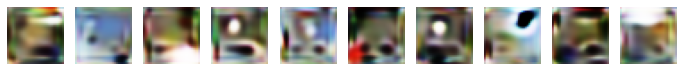

Iter:1050, LossG (fake:-12720.0000), LossD:3159.6631 (real:-13674.8496, fake:-11254.0576), WDistance:-2420.7920, GP:738.8712
Iter:1100, LossG (fake:-3831.9807), LossD:3373.9141 (real:-6708.2451, fake:-4362.0635), WDistance:-2346.1816, GP:1027.7325
Iter:1150, LossG (fake:-755.4921), LossD:4168.6997 (real:-2209.4473, fake:961.5034), WDistance:-3170.9507, GP:997.7490
Iter:1200, LossG (fake:-11740.9922), LossD:3303.6274 (real:-16892.9824, fake:-14536.1963), WDistance:-2356.7861, GP:946.8414
save G >> models/WGAN-GP-cifar10_G_iter1200.pt, D >> models/WGAN-GP-cifar10_D_iter1200.pt
Iter:1250, LossG (fake:-4323.6182), LossD:4035.3027 (real:-8059.4229, fake:-5296.5947), WDistance:-2762.8281, GP:1272.4746
Iter:1300, LossG (fake:-8920.4121), LossD:3784.2966 (real:-12442.8418, fake:-9880.1836), WDistance:-2562.6582, GP:1221.6384
Iter:1350, LossG (fake:-15288.8711), LossD:3593.9116 (real:-18710.7188, fake:-16306.4668), WDistance:-2404.2520, GP:1189.6597
Iter:1400, LossG (fake:-13525.3799), LossD:43

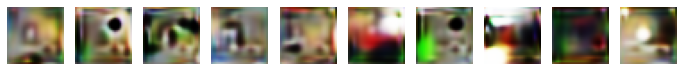

Iter:1550, LossG (fake:19133.2539), LossD:3434.3645 (real:16399.1328, fake:18656.2754), WDistance:-2257.1426, GP:1177.2219
Iter:1600, LossG (fake:-6111.0908), LossD:2745.0974 (real:-12168.7002, fake:-10207.8301), WDistance:-1960.8701, GP:784.2274
save G >> models/WGAN-GP-cifar10_G_iter1600.pt, D >> models/WGAN-GP-cifar10_D_iter1600.pt
Iter:1650, LossG (fake:-21996.7969), LossD:4540.5625 (real:-22075.3711, fake:-18858.1367), WDistance:-3217.2344, GP:1323.3281
Iter:1700, LossG (fake:17387.0586), LossD:4331.8916 (real:11541.8867, fake:14521.9258), WDistance:-2980.0391, GP:1351.8523
Iter:1750, LossG (fake:11996.8662), LossD:3149.2083 (real:11206.2500, fake:13306.3857), WDistance:-2100.1357, GP:1049.0725
Iter:1800, LossG (fake:-26752.9336), LossD:5329.2236 (real:-27389.5684, fake:-23512.9961), WDistance:-3876.5723, GP:1452.6511
save G >> models/WGAN-GP-cifar10_G_iter1800.pt, D >> models/WGAN-GP-cifar10_D_iter1800.pt
Iter:1850, LossG (fake:4980.6719), LossD:3217.6797 (real:-862.1329, fake:11

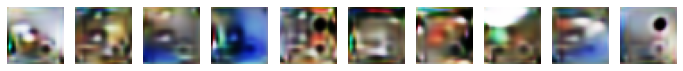

Iter:2050, LossG (fake:1661.6592), LossD:3596.8618 (real:-2674.5654, fake:-121.0154), WDistance:-2553.5500, GP:1043.3118
Iter:2100, LossG (fake:-789.5853), LossD:3981.5195 (real:-328.9952, fake:2394.9141), WDistance:-2723.9092, GP:1257.6104
Iter:2150, LossG (fake:4072.3691), LossD:2521.6558 (real:995.9661, fake:2789.0386), WDistance:-1793.0725, GP:728.5834
Iter:2200, LossG (fake:-27744.2188), LossD:5083.1797 (real:-26136.0312, fake:-22078.9414), WDistance:-4057.0898, GP:1026.0897
save G >> models/WGAN-GP-cifar10_G_iter2200.pt, D >> models/WGAN-GP-cifar10_D_iter2200.pt
Iter:2250, LossG (fake:-8106.0684), LossD:4066.5227 (real:-10631.1562, fake:-7808.7588), WDistance:-2822.3975, GP:1244.1252
Iter:2300, LossG (fake:23377.7383), LossD:2955.2798 (real:21122.2461, fake:23219.8652), WDistance:-2097.6191, GP:857.6608
Iter:2350, LossG (fake:14877.1328), LossD:2345.3115 (real:12234.3574, fake:13854.6699), WDistance:-1620.3125, GP:724.9991
Iter:2400, LossG (fake:6069.8813), LossD:2869.8157 (real:

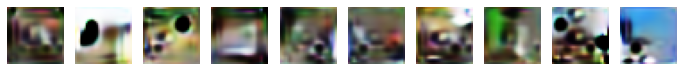

Iter:2550, LossG (fake:12682.0098), LossD:2416.2261 (real:8905.5840, fake:10565.9043), WDistance:-1660.3203, GP:755.9059
Iter:2600, LossG (fake:19154.5273), LossD:3046.9812 (real:16026.2715, fake:18251.3320), WDistance:-2225.0605, GP:821.9207
save G >> models/WGAN-GP-cifar10_G_iter2600.pt, D >> models/WGAN-GP-cifar10_D_iter2600.pt
Iter:2650, LossG (fake:-8005.2676), LossD:3480.9395 (real:-5178.9727, fake:-2563.9531), WDistance:-2615.0195, GP:865.9200
Iter:2700, LossG (fake:6767.9160), LossD:3001.2048 (real:4158.4248, fake:6333.5195), WDistance:-2175.0947, GP:826.1101
Iter:2750, LossG (fake:14099.9688), LossD:2240.4158 (real:11652.4834, fake:13186.4844), WDistance:-1534.0010, GP:706.4147
Iter:2800, LossG (fake:2138.6365), LossD:3071.0933 (real:172.4939, fake:2267.3098), WDistance:-2094.8159, GP:976.2775
save G >> models/WGAN-GP-cifar10_G_iter2800.pt, D >> models/WGAN-GP-cifar10_D_iter2800.pt
Iter:2850, LossG (fake:30831.7617), LossD:3289.6567 (real:27593.4277, fake:29915.4160), WDistanc

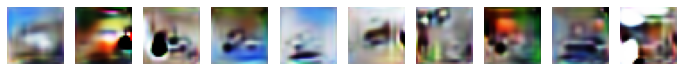

Iter:3050, LossG (fake:14403.7402), LossD:3234.0396 (real:13501.9844, fake:15785.1045), WDistance:-2283.1201, GP:950.9194
Iter:3100, LossG (fake:14403.3809), LossD:2814.6096 (real:13445.4219, fake:15317.1348), WDistance:-1871.7129, GP:942.8967
Iter:3150, LossG (fake:-10898.0889), LossD:5934.6206 (real:-14516.7344, fake:-10596.1104), WDistance:-3920.6240, GP:2013.9965
Iter:3200, LossG (fake:19369.8438), LossD:2491.7065 (real:20385.0742, fake:21934.1016), WDistance:-1549.0273, GP:942.6791
save G >> models/WGAN-GP-cifar10_G_iter3200.pt, D >> models/WGAN-GP-cifar10_D_iter3200.pt
Iter:3250, LossG (fake:17342.1758), LossD:2070.2603 (real:13983.7891, fake:15361.9238), WDistance:-1378.1348, GP:692.1255
Iter:3300, LossG (fake:16649.6113), LossD:2880.0042 (real:14091.7646, fake:16018.9883), WDistance:-1927.2236, GP:952.7805
Iter:3350, LossG (fake:4754.2651), LossD:2675.7839 (real:4849.5801, fake:6818.4707), WDistance:-1968.8906, GP:706.8932
Iter:3400, LossG (fake:5392.7139), LossD:4034.9888 (rea

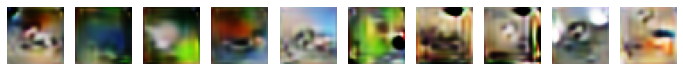

Iter:3550, LossG (fake:18372.7930), LossD:1752.8877 (real:17519.0586, fake:18810.1855), WDistance:-1291.1270, GP:461.7607
Iter:3600, LossG (fake:17530.0098), LossD:1714.8346 (real:18656.7148, fake:19734.3809), WDistance:-1077.6660, GP:637.1686
save G >> models/WGAN-GP-cifar10_G_iter3600.pt, D >> models/WGAN-GP-cifar10_D_iter3600.pt
Iter:3650, LossG (fake:40508.6719), LossD:2981.6694 (real:38268.6250, fake:40362.8750), WDistance:-2094.2500, GP:887.4194
Iter:3700, LossG (fake:12226.3359), LossD:2190.5498 (real:11206.6211, fake:12920.5518), WDistance:-1713.9307, GP:476.6193
Iter:3750, LossG (fake:16563.8594), LossD:2433.0449 (real:16926.1016, fake:18523.7734), WDistance:-1597.6719, GP:835.3730
Iter:3800, LossG (fake:7779.2759), LossD:2326.7319 (real:7311.5674, fake:8914.6758), WDistance:-1603.1084, GP:723.6235
save G >> models/WGAN-GP-cifar10_G_iter3800.pt, D >> models/WGAN-GP-cifar10_D_iter3800.pt
Iter:3850, LossG (fake:30032.6250), LossD:5325.3530 (real:25363.5156, fake:29351.1465), WDi

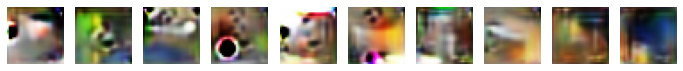

Iter:4050, LossG (fake:-1604.0326), LossD:2208.5957 (real:-2044.4514, fake:-396.0442), WDistance:-1648.4072, GP:560.1885
Iter:4100, LossG (fake:1743.0529), LossD:3696.9697 (real:1534.9983, fake:4384.6553), WDistance:-2849.6570, GP:847.3129
Iter:4150, LossG (fake:23628.0977), LossD:2140.9893 (real:19868.1055, fake:21491.3867), WDistance:-1623.2812, GP:517.7081
Iter:4200, LossG (fake:14653.6719), LossD:1815.0625 (real:12917.6670, fake:14108.6953), WDistance:-1191.0283, GP:624.0342
save G >> models/WGAN-GP-cifar10_G_iter4200.pt, D >> models/WGAN-GP-cifar10_D_iter4200.pt
Iter:4250, LossG (fake:1212.4165), LossD:3094.3013 (real:1799.8081, fake:4042.2988), WDistance:-2242.4907, GP:851.8106
Iter:4300, LossG (fake:7220.8638), LossD:2365.3074 (real:5027.0576, fake:6838.5605), WDistance:-1811.5029, GP:553.8044
Iter:4350, LossG (fake:12517.8672), LossD:1648.3025 (real:11561.8125, fake:12669.8926), WDistance:-1108.0801, GP:540.2224
Iter:4400, LossG (fake:17927.8359), LossD:1614.4984 (real:14405.34

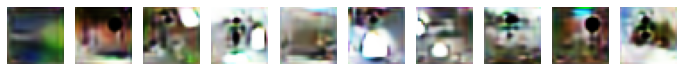

Iter:4550, LossG (fake:12582.5566), LossD:1463.9259 (real:13157.4775, fake:14178.8271), WDistance:-1021.3496, GP:442.5763
Iter:4600, LossG (fake:38979.1992), LossD:3628.0718 (real:32964.5586, fake:35588.1094), WDistance:-2623.5508, GP:1004.5211
save G >> models/WGAN-GP-cifar10_G_iter4600.pt, D >> models/WGAN-GP-cifar10_D_iter4600.pt
Iter:4650, LossG (fake:17617.4570), LossD:1786.7021 (real:16745.0977, fake:17935.4023), WDistance:-1190.3047, GP:596.3975
Iter:4700, LossG (fake:1617.0005), LossD:3717.1987 (real:-800.9402, fake:1861.3484), WDistance:-2662.2886, GP:1054.9102
Iter:4750, LossG (fake:6763.5137), LossD:2207.4561 (real:7848.1826, fake:9359.8672), WDistance:-1511.6846, GP:695.7716
Iter:4800, LossG (fake:19667.5938), LossD:2439.0342 (real:17725.1172, fake:19413.9414), WDistance:-1688.8242, GP:750.2098
save G >> models/WGAN-GP-cifar10_G_iter4800.pt, D >> models/WGAN-GP-cifar10_D_iter4800.pt
Iter:4850, LossG (fake:18935.7246), LossD:2775.8889 (real:15578.6846, fake:17541.5430), WDis

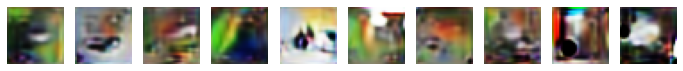

Iter:5050, LossG (fake:38852.5859), LossD:3222.1143 (real:35763.7422, fake:38165.8516), WDistance:-2402.1094, GP:820.0049
Iter:5100, LossG (fake:29860.4395), LossD:2377.6973 (real:22662.6367, fake:24484.0059), WDistance:-1821.3691, GP:556.3282
Iter:5150, LossG (fake:7373.4150), LossD:1328.0817 (real:4796.0352, fake:5746.5859), WDistance:-950.5508, GP:377.5309
Iter:5200, LossG (fake:166.5227), LossD:2289.6187 (real:149.7108, fake:1741.3123), WDistance:-1591.6014, GP:698.0172
save G >> models/WGAN-GP-cifar10_G_iter5200.pt, D >> models/WGAN-GP-cifar10_D_iter5200.pt
Iter:5250, LossG (fake:38071.8984), LossD:3491.0806 (real:33335.5508, fake:35796.1875), WDistance:-2460.6367, GP:1030.4438
Iter:5300, LossG (fake:6945.9492), LossD:1630.4590 (real:6017.5830, fake:7277.9912), WDistance:-1260.4082, GP:370.0508
Iter:5350, LossG (fake:-11507.2080), LossD:3086.5879 (real:-12226.0723, fake:-9853.3057), WDistance:-2372.7666, GP:713.8213
Iter:5400, LossG (fake:15913.5605), LossD:1493.1853 (real:12511.4

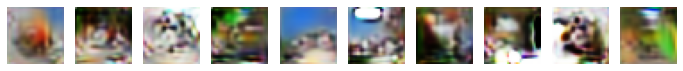

Iter:5550, LossG (fake:4232.3677), LossD:2087.2622 (real:1870.7977, fake:3487.5415), WDistance:-1616.7438, GP:470.5185
Iter:5600, LossG (fake:15659.1641), LossD:2289.2024 (real:11987.7520, fake:13798.4287), WDistance:-1810.6768, GP:478.5257
save G >> models/WGAN-GP-cifar10_G_iter5600.pt, D >> models/WGAN-GP-cifar10_D_iter5600.pt
Iter:5650, LossG (fake:4251.9028), LossD:1708.1672 (real:2257.6995, fake:3369.0803), WDistance:-1111.3809, GP:596.7864
Iter:5700, LossG (fake:7448.9536), LossD:1799.7419 (real:4177.5542, fake:5502.3701), WDistance:-1324.8159, GP:474.9261
Iter:5750, LossG (fake:7124.5225), LossD:1526.2367 (real:7713.0776, fake:8845.5703), WDistance:-1132.4927, GP:393.7440
Iter:5800, LossG (fake:42076.8945), LossD:4330.7822 (real:37372.1758, fake:40423.2422), WDistance:-3051.0664, GP:1279.7156
save G >> models/WGAN-GP-cifar10_G_iter5800.pt, D >> models/WGAN-GP-cifar10_D_iter5800.pt
Iter:5850, LossG (fake:-4486.9868), LossD:1921.6470 (real:-3762.6829, fake:-2198.0488), WDistance:-

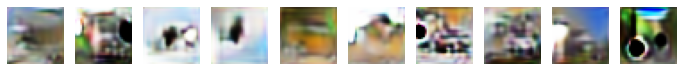

Iter:6050, LossG (fake:7723.4062), LossD:1625.2686 (real:9560.4395, fake:10585.0938), WDistance:-1024.6543, GP:600.6143
Iter:6100, LossG (fake:18480.8574), LossD:1600.8745 (real:16120.7676, fake:17275.9277), WDistance:-1155.1602, GP:445.7144
Iter:6150, LossG (fake:-3211.5244), LossD:2180.6865 (real:-3318.0576, fake:-1787.2223), WDistance:-1530.8353, GP:649.8512
Iter:6200, LossG (fake:6669.6260), LossD:2639.2310 (real:4988.3301, fake:7086.4106), WDistance:-2098.0806, GP:541.1503
save G >> models/WGAN-GP-cifar10_G_iter6200.pt, D >> models/WGAN-GP-cifar10_D_iter6200.pt
Iter:6250, LossG (fake:-22218.4375), LossD:2864.6992 (real:-25374.2227, fake:-23349.1875), WDistance:-2025.0352, GP:839.6642
Iter:6300, LossG (fake:17963.1445), LossD:2021.7383 (real:16248.1699, fake:17631.9648), WDistance:-1383.7949, GP:637.9434
Iter:6350, LossG (fake:16348.2930), LossD:1576.5769 (real:13972.6465, fake:15153.0146), WDistance:-1180.3682, GP:396.2088
Iter:6400, LossG (fake:13274.5234), LossD:1787.9592 (real:

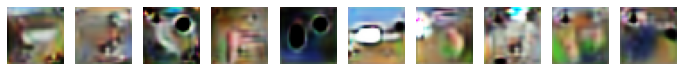

Iter:6550, LossG (fake:10797.1064), LossD:2946.0811 (real:9202.6738, fake:11304.7656), WDistance:-2102.0918, GP:843.9891
Iter:6600, LossG (fake:8054.0107), LossD:1457.2450 (real:5062.9121, fake:6036.4038), WDistance:-973.4917, GP:483.7533
save G >> models/WGAN-GP-cifar10_G_iter6600.pt, D >> models/WGAN-GP-cifar10_D_iter6600.pt
Iter:6650, LossG (fake:22322.3242), LossD:2417.0850 (real:19530.2305, fake:21279.4316), WDistance:-1749.2012, GP:667.8839
Iter:6700, LossG (fake:15287.8828), LossD:2322.5576 (real:12611.4609, fake:14293.7607), WDistance:-1682.2998, GP:640.2579
Iter:6750, LossG (fake:11037.7500), LossD:1596.7384 (real:9375.3672, fake:10518.4570), WDistance:-1143.0898, GP:453.6485
Iter:6800, LossG (fake:11557.2441), LossD:1320.0955 (real:7866.4609, fake:8754.3047), WDistance:-887.8438, GP:432.2517
save G >> models/WGAN-GP-cifar10_G_iter6800.pt, D >> models/WGAN-GP-cifar10_D_iter6800.pt
Iter:6850, LossG (fake:8115.9014), LossD:1600.0071 (real:6063.1768, fake:7129.7905), WDistance:-1

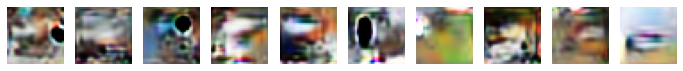

Iter:7050, LossG (fake:7983.0562), LossD:2021.4989 (real:6924.9023, fake:8379.3955), WDistance:-1454.4932, GP:567.0057
Iter:7100, LossG (fake:11468.5479), LossD:2135.4189 (real:9416.9912, fake:10995.1680), WDistance:-1578.1768, GP:557.2422
Iter:7150, LossG (fake:9944.1094), LossD:1546.2744 (real:7545.5679, fake:8670.2002), WDistance:-1124.6323, GP:421.6421
Iter:7200, LossG (fake:12253.0742), LossD:1741.3143 (real:11913.0527, fake:13278.7656), WDistance:-1365.7129, GP:375.6014
save G >> models/WGAN-GP-cifar10_G_iter7200.pt, D >> models/WGAN-GP-cifar10_D_iter7200.pt
Iter:7250, LossG (fake:12099.8516), LossD:1705.4036 (real:10440.0117, fake:11788.9922), WDistance:-1348.9805, GP:356.4231
Iter:7300, LossG (fake:20994.0137), LossD:2178.5701 (real:18380.9961, fake:19953.5000), WDistance:-1572.5039, GP:606.0661
Iter:7350, LossG (fake:10998.7686), LossD:1590.0626 (real:7250.7427, fake:8399.4570), WDistance:-1148.7144, GP:441.3482
Iter:7400, LossG (fake:4674.6021), LossD:1828.9092 (real:3862.656

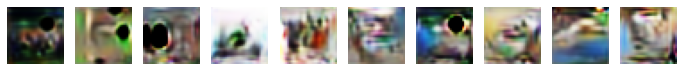

Iter:7550, LossG (fake:16068.7412), LossD:1995.3945 (real:14325.5947, fake:15688.8975), WDistance:-1363.3027, GP:632.0917
Iter:7600, LossG (fake:6919.4365), LossD:1893.1786 (real:5140.3818, fake:6603.8008), WDistance:-1463.4189, GP:429.7596
save G >> models/WGAN-GP-cifar10_G_iter7600.pt, D >> models/WGAN-GP-cifar10_D_iter7600.pt
Iter:7650, LossG (fake:11291.8926), LossD:1953.9619 (real:9136.6289, fake:10682.9609), WDistance:-1546.3320, GP:407.6299
Iter:7700, LossG (fake:7593.9438), LossD:1291.7393 (real:7587.2793, fake:8561.4668), WDistance:-974.1875, GP:317.5518
Iter:7750, LossG (fake:6724.8867), LossD:1163.0146 (real:6477.8169, fake:7325.7461), WDistance:-847.9292, GP:315.0854
Iter:7800, LossG (fake:5211.8564), LossD:2133.5911 (real:4812.9961, fake:6424.4375), WDistance:-1611.4414, GP:522.1496
save G >> models/WGAN-GP-cifar10_G_iter7800.pt, D >> models/WGAN-GP-cifar10_D_iter7800.pt
Iter:7850, LossG (fake:18127.1289), LossD:1527.6035 (real:14269.9463, fake:15461.9951), WDistance:-1192

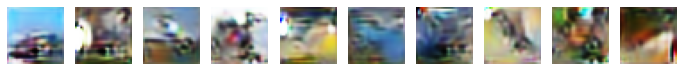

Iter:8050, LossG (fake:3797.8350), LossD:836.4330 (real:4282.6196, fake:4913.0283), WDistance:-630.4087, GP:206.0243
Iter:8100, LossG (fake:16885.4551), LossD:1172.9769 (real:16589.4062, fake:17431.4258), WDistance:-842.0195, GP:330.9574
Iter:8150, LossG (fake:5700.0762), LossD:1519.8094 (real:6252.9551, fake:7469.6748), WDistance:-1216.7197, GP:303.0897
Iter:8200, LossG (fake:1911.9266), LossD:1171.7878 (real:675.9025, fake:1447.4573), WDistance:-771.5548, GP:400.2330
save G >> models/WGAN-GP-cifar10_G_iter8200.pt, D >> models/WGAN-GP-cifar10_D_iter8200.pt
Iter:8250, LossG (fake:13184.7754), LossD:1471.0326 (real:10948.4746, fake:11963.8594), WDistance:-1015.3848, GP:455.6478
Iter:8300, LossG (fake:11007.7969), LossD:1026.2913 (real:7619.1025, fake:8273.4629), WDistance:-654.3604, GP:371.9309
Iter:8350, LossG (fake:16908.1445), LossD:1162.9332 (real:13872.5449, fake:14682.1504), WDistance:-809.6055, GP:353.3278
Iter:8400, LossG (fake:1995.1746), LossD:1381.3618 (real:62.8310, fake:101

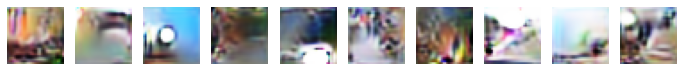

Iter:8550, LossG (fake:-4013.6484), LossD:1098.3911 (real:-4100.5225, fake:-3349.9961), WDistance:-750.5264, GP:347.8648
Iter:8600, LossG (fake:-1526.6945), LossD:1115.7100 (real:-1396.0652, fake:-660.3851), WDistance:-735.6801, GP:380.0299
save G >> models/WGAN-GP-cifar10_G_iter8600.pt, D >> models/WGAN-GP-cifar10_D_iter8600.pt
Iter:8650, LossG (fake:28012.5234), LossD:2147.8296 (real:24967.4453, fake:26557.4258), WDistance:-1589.9805, GP:557.8490
Iter:8700, LossG (fake:-11194.6260), LossD:1537.7462 (real:-9465.6660, fake:-8312.8789), WDistance:-1152.7871, GP:384.9591
Iter:8750, LossG (fake:3667.4453), LossD:1371.0887 (real:2683.5918, fake:3689.4971), WDistance:-1005.9053, GP:365.1835
Iter:8800, LossG (fake:-6370.8027), LossD:1385.5544 (real:-6478.1133, fake:-5480.0762), WDistance:-998.0371, GP:387.5174
save G >> models/WGAN-GP-cifar10_G_iter8800.pt, D >> models/WGAN-GP-cifar10_D_iter8800.pt
Iter:8850, LossG (fake:-760.0951), LossD:1038.8370 (real:562.8951, fake:1378.6384), WDistance:

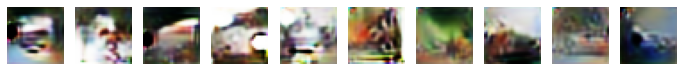

Iter:9050, LossG (fake:-4776.8408), LossD:1779.2661 (real:-6622.1064, fake:-5332.3057), WDistance:-1289.8008, GP:489.4653
Iter:9100, LossG (fake:7466.1167), LossD:1277.3440 (real:7133.2979, fake:8009.7974), WDistance:-876.4995, GP:400.8445
Iter:9150, LossG (fake:-6896.6562), LossD:1610.5902 (real:-8283.5254, fake:-7058.2520), WDistance:-1225.2734, GP:385.3168
Iter:9200, LossG (fake:-3693.1509), LossD:1605.4734 (real:-3540.4819, fake:-2329.1631), WDistance:-1211.3188, GP:394.1545
save G >> models/WGAN-GP-cifar10_G_iter9200.pt, D >> models/WGAN-GP-cifar10_D_iter9200.pt
Iter:9250, LossG (fake:-4566.5000), LossD:1282.3933 (real:-5800.9814, fake:-4904.7373), WDistance:-896.2441, GP:386.1491
Iter:9300, LossG (fake:11717.2910), LossD:1313.8923 (real:7938.9170, fake:8946.0410), WDistance:-1007.1240, GP:306.7683
Iter:9350, LossG (fake:-2650.0994), LossD:886.5337 (real:-1280.4900, fake:-626.2490), WDistance:-654.2410, GP:232.2927
Iter:9400, LossG (fake:13077.5811), LossD:1273.0248 (real:14475.84

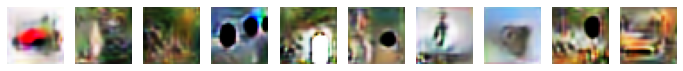

Iter:9550, LossG (fake:12935.4346), LossD:1235.0728 (real:10242.5508, fake:11151.8389), WDistance:-909.2881, GP:325.7847
Iter:9600, LossG (fake:32202.0586), LossD:3402.9792 (real:28089.0000, fake:30670.3848), WDistance:-2581.3848, GP:821.5945
save G >> models/WGAN-GP-cifar10_G_iter9600.pt, D >> models/WGAN-GP-cifar10_D_iter9600.pt
Iter:9650, LossG (fake:16778.1484), LossD:1617.6118 (real:10429.8223, fake:11700.2900), WDistance:-1270.4678, GP:347.1441
Iter:9700, LossG (fake:-4193.6240), LossD:2349.8154 (real:-5154.5010, fake:-3449.5225), WDistance:-1704.9785, GP:644.8370
Iter:9750, LossG (fake:3039.3274), LossD:1257.1310 (real:4411.3286, fake:5353.9321), WDistance:-942.6035, GP:314.5275
Iter:9800, LossG (fake:12157.6875), LossD:1798.4486 (real:9414.9648, fake:10828.4883), WDistance:-1413.5234, GP:384.9252
save G >> models/WGAN-GP-cifar10_G_iter9800.pt, D >> models/WGAN-GP-cifar10_D_iter9800.pt
Iter:9850, LossG (fake:7473.3931), LossD:1049.6456 (real:1812.5020, fake:2592.3843), WDistance

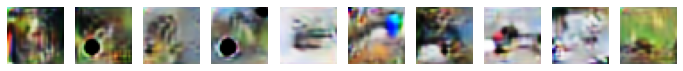

final paramters were saved to G >> models/WGAN-GP-cifar10_G_final.pt, D >> models/WGAN-GP-cifar10_D_final.pt
loss was saved to >> result/WGAN-GP-cifar10_loss.txt


In [10]:
# train
def train():
    # model
    G = Generator().to(cfg.DEVICE)
    D = Discriminator().to(cfg.DEVICE)

    summary(G, (cfg.INPUT_Z_DIM, 1, 1), device=cfg.DEVICE_TYPE)
    summary(D, (cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH), device=cfg.DEVICE_TYPE)
    
    G.apply(weights_init)
    D.apply(weights_init)

    opt_G = cfg.TRAIN.OPTIMIZER_G(G.parameters(), **cfg.TRAIN.LEARNING_PARAMS_G)
    opt_D = cfg.TRAIN.OPTIMIZER_D(D.parameters(), **cfg.TRAIN.LEARNING_PARAMS_D)

    #path_dict = data_load(cfg)
    #paths = path_dict['paths']
    #paths_gt = path_dict['paths_gt']

    trainset = torchvision.datasets.CIFAR10(root=cfg.TRAIN.DATA_PATH , train=True, download=True, transform=None)
    train_Xs = trainset.data
    train_ys = trainset.targets

    # training
    mbi = 0
    train_N = len(train_Xs)
    train_ind = np.arange(train_N)
    np.random.seed(0)
    np.random.shuffle(train_ind)

    list_iter = []
    list_loss_G = []
    list_loss_D = []
    list_loss_D_real = []
    list_loss_D_fake = []
    list_loss_WDistance = []
    list_loss_GP = []

    ones = torch.FloatTensor([1]).to(cfg.DEVICE)
    minus_ones = ones * -1

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        if mbi + cfg.TRAIN.MINIBATCH > train_N:
            mb_ind = train_ind[mbi:]
            np.random.shuffle(train_ind)
            mb_ind = np.hstack((mb_ind, train_ind[ : (cfg.TRAIN.MINIBATCH - (train_N - mbi))]))
            mbi = cfg.TRAIN.MINIBATCH - (train_N - mbi)
        else:
            mb_ind = train_ind[mbi : mbi + cfg.TRAIN.MINIBATCH]
            mbi += cfg.TRAIN.MINIBATCH

        # update D
        for _ in range(cfg.TRAIN.WGAN_CRITIC_N):
            opt_D.zero_grad()

            # sample X
            Xs = torch.tensor(preprocess(train_Xs[mb_ind], cfg, cfg.OUTPUT_MODE), dtype=torch.float).to(cfg.DEVICE)

            # sample x
            z = np.random.uniform(-1, 1, size=(cfg.TRAIN.MINIBATCH, cfg.INPUT_Z_DIM, 1, 1))
            z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

            # forward
            Gz = G(z)
            loss_D_fake = D(Gz).mean(0).view(1)
            loss_D_real = D(Xs).mean(0).view(1)
            
            #---
            # Gradient Penalty
            #---
            # sample epsilon from [0, 1]
            epsilon = np.random.random()

            # sample x_hat 
            x_hat = (epsilon * Xs + (1 - epsilon) * Gz).requires_grad_(True)
            
            Dx_hat = D(x_hat)
            musk = torch.ones_like(Dx_hat)
            gradients = torch.autograd.grad(Dx_hat, x_hat, grad_outputs=musk, retain_graph=True, create_graph=True, allow_unused=True)[0]
            gradients = gradients.reshape(-1, 1)
            gradient_penalty = cfg.TRAIN.WGAN_GP_LAMBDA * ((gradients.norm(2, dim=1) - 1) ** 2).mean()
            
            # loss backward
            loss_D_real.backward(ones, retain_graph=True)
            loss_D_fake.backward(minus_ones, retain_graph=True)
            gradient_penalty.backward(retain_graph=True)

            loss_D = loss_D_fake - loss_D_real + gradient_penalty
            Wasserstein_distance = loss_D_real - loss_D_fake

            opt_D.step()
            

        # update G
        opt_G.zero_grad()
        z = np.random.uniform(-1, 1, size=(cfg.TRAIN.MINIBATCH, cfg.INPUT_Z_DIM, 1, 1))
        z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)
        loss_G = D(G(z)).mean(0).view(1)
        loss_G.backward(ones)
        opt_G.step()

        progres_bar += '|'
        print('\r' + progres_bar, end='')

        _loss_G = loss_G.item()
        _loss_D = loss_D.item()
        _loss_D_real = loss_D_real.item()
        _loss_D_fake = loss_D_fake.item()
        _Wasserstein_distance = Wasserstein_distance.item()
        _gradient_penalty = gradient_penalty.item()

        if (i + 1) % 10 == 0:
            progres_bar += str(i + 1)
            print('\r' + progres_bar, end='')

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss_G.append(_loss_G)
                list_loss_D.append(_loss_D)
                list_loss_D_real.append(_loss_D_real)
                list_loss_D_fake.append(_loss_D_fake)
                list_loss_WDistance.append(_Wasserstein_distance)
                list_loss_GP.append(_gradient_penalty)
                
        # display training state
        if (i + 1) % cfg.TRAIN.DISPAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, LossG (fake:{:.4f}), LossD:{:.4f} (real:{:.4f}, fake:{:.4f}), WDistance:{:.4f}, GP:{:.4f}'.format(
                i + 1, _loss_G, _loss_D, _loss_D_real, _loss_D_fake, _Wasserstein_distance, _gradient_penalty))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('iter{}'.format(i + 1))
            D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(G.state_dict(), G_save_path)
            torch.save(D.state_dict(), D_save_path)
            print('save G >> {}, D >> {}'.format(G_save_path, D_save_path))

        # save process result
        if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
            result_show(
                G, z, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE, show=True)

    G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
    D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final')
    torch.save(G.state_dict(), G_save_path)
    torch.save(D.state_dict(), D_save_path)
    print('final paramters were saved to G >> {}, D >> {}'.format(G_save_path, D_save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss_G' : list_loss_G, 'loss_D' : list_loss_D, 
                            'loss_D_real' : list_loss_D_real, 'loss_D_fake' : list_loss_D_fake, 'Wasserstein_Distance' : list_loss_WDistance,
                          'GP' : list_loss_GP})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

## Test

--------------------
test function
--------------------
result was saved to >> result/WGAN-GP-cifar10_result_1.jpg


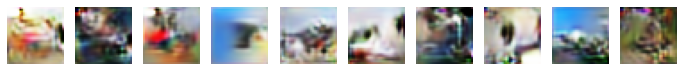

result was saved to >> result/WGAN-GP-cifar10_result_2.jpg


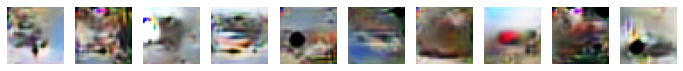

In [12]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    G = Generator().to(cfg.DEVICE)
    G.load_state_dict(torch.load(cfg.TEST.MODEL_G_PATH, map_location=torch.device(cfg.DEVICE)))
    G.eval()

    np.random.seed(0)
    
    for i in range(cfg.TEST.ITERATION):
        z = np.random.uniform(-1, 1, size=(cfg.TEST.MINIBATCH, cfg.INPUT_Z_DIM, 1, 1))
        z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

        result_show(G, z, cfg.TEST.RESULT_IMAGE_PATH.format(i + 1), save=cfg.TEST.RESULT_SAVE, show=True)

test()

In [0]:
def arg_parse():
    parser = argparse.ArgumentParser(description='CNN implemented with Keras')
    parser.add_argument('--train', dest='train', action='store_true')
    parser.add_argument('--test', dest='test', action='store_true')
    args = parser.parse_args()
    return args

# main
if __name__ == '__main__':
    args = arg_parse()

    if args.train:
        train()
    if args.test:
        test()

    if not (args.train or args.test):
        print("please select train or test flag")
        print("train: python main.py --train")
        print("test:  python main.py --test")
        print("both:  python main.py --train --test")
